In [1]:
from __future__ import division
import os
import sys
import numpy as np
import scipy.io
import scipy.misc
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
%matplotlib inline

In [2]:
OUTPUT_DIR = 'alpha=1_beta=1000_5style_5content_gain/'
STYLE_IMAGE = 'data/warped_aligned_art.jpg'
CONTENT_IMAGE = 'data/warped_aligned_headshot.jpg'

In [3]:
NOISE_RATIO = 0.6
BETA =  1000 #style_Loss
ALPHA = 1 #content loss
VGG_MODEL = 'data/imagenet-vgg-verydeep-19.mat'
MEAN_VALUES = np.array([123.68,116.779,103.939]).reshape((1,1,1,3))
STYLE_LAYERS = [('conv1_1', 0.5), ('conv2_1', 1.0), ('conv3_1', 1.5), ('conv4_1', 3.0), ('conv5_1', 4.0)]
#STYLE_LAYERS = [('conv3_1', 0.5), ('conv4_1', 0.5)]
CONTENT_LAYERS = [('conv1_1', 4.0), ('conv2_1', 3.0), ('conv3_1', 1.5), ('conv4_1', 1.0), ('conv5_1', 0.5)]
#CONTENT_LAYERS = [('conv4_1', 0.5)]
ITERATIONS = 500
EPSILON = 10 ** (-4)
GMIN = 0.7
GMAX = 5

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


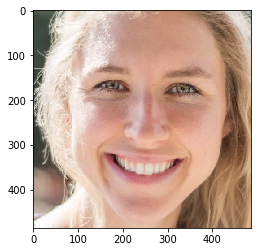

In [4]:
content_image = scipy.misc.imread(CONTENT_IMAGE)
imshow(content_image)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


The shape of the target is  (486, 486, 3)
The shape of the style is  (486, 486, 3)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


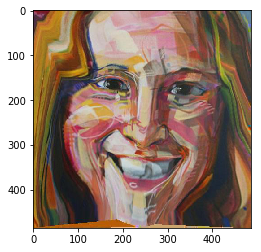

In [5]:
style_image = scipy.misc.imread(STYLE_IMAGE)
style_image = scipy.misc.imresize(style_image, content_image.shape)
scipy.misc.imsave(STYLE_IMAGE, style_image)
imshow(style_image)
print('The shape of the target is ', content_image.shape)
print('The shape of the style is ', style_image.shape)

In [6]:
def load_vgg_model(path, image_height, image_width, color_channel, pool="avg"):
    vgg = scipy.io.loadmat(path)
    vgg_layers = vgg['layers']
    
    def _weights(layer, expected_layer_name):
        W = vgg_layers[0][layer][0][0][2][0][0] 
        b = vgg_layers[0][layer][0][0][2][0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert layer_name == expected_layer_name
        return W,b
    
    def _relu(conv2d_layer):
        return tf.nn.relu(conv2d_layer)
    
    def _conv2d(prev_layer, layer, layer_name):
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b,(b.size)))
        return tf.nn.conv2d(prev_layer,filter=W, strides=[1,1,1,1], padding='SAME')+b
    
    def _conv2d_relu(prev_layer, layer, layer_name):
        return _relu(_conv2d(prev_layer, layer, layer_name))
    
    def _avgpool(prev_layer):
        return tf.nn.avg_pool(prev_layer, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    def _maxpool(prev_layer):
        return tf.nn.max_pool(prev_layer, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    graph = {}
    graph['input'] = tf.Variable(np.zeros((1,image_height,image_width,color_channel)), dtype='float32')
    graph['conv1_1'] = _conv2d_relu(graph['input'],0,'conv1_1')
    graph['conv1_2'] = _conv2d_relu(graph['conv1_1'],2,'conv1_2')
    if pool == "max":
        graph['pool1'] = _maxpool(graph['conv1_2'])
    else:
        graph['pool1'] = _avgpool(graph['conv1_2'])     
    graph['conv2_1']  = _conv2d_relu(graph['pool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    if pool == "max":
        graph['pool2'] = _maxpool(graph['conv2_2'])
    else:
        graph['pool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['pool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    if pool == "max":
        graph['pool3'] = _maxpool(graph['conv3_4'])
    else:
        graph['pool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['pool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    if pool == "max":
        graph['pool4'] = _maxpool(graph['conv4_4'])
    else:
        graph['pool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['pool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    if pool == "max":
        graph['pool5'] = _maxpool(graph['conv5_4'])
    else:
        graph['pool5'] = _avgpool(graph['conv5_4'])
    return graph

In [7]:
def compute_gains_map(model, content_image, style_image, CONTENT_LAYERS):
    gains_map = {}
    for layer_name, coeff in CONTENT_LAYERS:
        sess.run(model['input'].assign(content_image))
        a_C = sess.run(model[layer_name])
        
        sess.run(model['input'].assign(style_image))
        a_S = sess.run(model[layer_name])
        
        G = a_S / (a_C + EPSILON)
        
        G_clamped = tf.math.maximum(tf.math.minimum(G, GMAX), GMIN)
        
        gains_map[layer_name]=G_clamped
        print("Gains Map Computed")
        print(G_clamped.shape)
        
    return gains_map

In [8]:
def compute_content_cost(model, CONTENT_LAYERS, gains_map):
    def _compute_layer_content_cost(a_C, a_G):
        # Retrieve dimensions from a_G (≈1 line)
        m, n_H, n_W, n_C = a_G.get_shape().as_list()
        # Reshape a_C and a_G (≈2 lines)
        a_C_unrolled = tf.reshape(a_C,[n_C, n_H*n_W])
        a_G_unrolled = tf.reshape(a_G,[n_C, n_H*n_W])
        # compute the cost with tensorflow (≈1 line)
        J_content_layer = 1/(4*n_H*n_W*n_C)*tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled)))
        return J_content_layer
    
    
    J_content = 0
    
    for layer_name, coeff in CONTENT_LAYERS:
        # Select the output tensor of layer conv4_2
        out = model[layer_name]

        # Set a_C to be the hidden layer activation from the layer we have selected
        a_C = sess.run(out)
        
        G_clamped = gains_map[layer_name]        
        a_M = a_C * sess.run(G_clamped)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_content_layer = _compute_layer_content_cost(a_M, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_content += coeff * J_content_layer
        
    return J_content

In [9]:
def compute_style_cost(model, STYLE_LAYERS):
    def _gram_matrix(F, N, M):
        Ft = tf.reshape(F, (M, N))
        return tf.matmul(tf.transpose(Ft), Ft)   
    
    def _compute_layer_style_cost(a_S, a_G):
        N = a_S.shape[3]
        M = a_S.shape[1]*a_S.shape[2]

        # Computing gram_matrices for both images S and G
        GS = _gram_matrix(a_S, N, M)
        GG = _gram_matrix(a_G, N, M)

        # Computing the loss (≈1 line)
        J_style_layer = (1/(4*N**2*M**2))*tf.reduce_sum(tf.pow(GG-GS,2))
        return J_style_layer
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = _compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

In [10]:
def generate_noise_image(content_image, noise_ratio = NOISE_RATIO):
    nx, ny, nz = content_image[0].shape
    noise_image = np.random.uniform(-20, 20, (1, nx, ny, nz)).astype('float32')
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    return input_image

In [11]:
def process_image(image):
    image = np.reshape(image, ((1,) + image.shape))
    image = image - MEAN_VALUES
    return image

In [12]:
def save_image(path, image):
    image = image + MEAN_VALUES
    image = image[0]
    image = np.clip(image, 0, 255).astype('uint8')
    scipy.misc.imsave(path, image)

In [13]:
sess = tf.InteractiveSession()
content_image = process_image(content_image)
style_image = process_image(style_image)
input_image = generate_noise_image(content_image)

model = load_vgg_model( VGG_MODEL, input_image[0].shape[0], input_image[0].shape[1], input_image[0].shape[2], "max") 

# sess.run(tf.initialize_all_variables())

# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Compute the content cost
gains_map = compute_gains_map(model, content_image, style_image, CONTENT_LAYERS)
content_loss = compute_content_cost(model, CONTENT_LAYERS, gains_map)

# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
style_loss = compute_style_cost(model, STYLE_LAYERS)

Instructions for updating:
Colocations handled automatically by placer.
Gains Map Computed
(1, 486, 486, 64)
Gains Map Computed
(1, 243, 243, 128)
Gains Map Computed
(1, 122, 122, 256)
Gains Map Computed
(1, 61, 61, 512)
Gains Map Computed
(1, 31, 31, 512)


In [14]:
total_loss = ALPHA * content_loss + BETA * style_loss
optimizer = tf.train.AdamOptimizer(2.0)
train_step = optimizer.minimize(total_loss)

In [15]:
init = tf.global_variables_initializer()
sess.run(init)
sess.run(model['input'].assign(input_image)) 

print("started iteration")
difference = []
mixed_image_old = input_image[0]
for it in range(ITERATIONS): 
    sess.run(train_step) 

    mixed_image = sess.run(model['input'])
    difference.append(np.abs(np.mean(mixed_image_old - mixed_image[0])))
    mixed_image_old = mixed_image[0]
    
    print(it , " ")
    if it% 50 == 0: 
        
        print('Iteration %d' % (it)) 
        print('sum : ', sess.run( tf.reduce_sum( mixed_image))) 
        print('cost: ', sess.run( total_loss)) 
        if not os.path.exists( OUTPUT_DIR): 
            os.mkdir( OUTPUT_DIR) 
        filename = '%s%d.png' % (OUTPUT_DIR, it) 
        save_image( filename, mixed_image)

started iteration
0  
Iteration 0
sum :  14230313.0
cost:  23258045000000.0


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """


1  
2  
3  
4  
5  
6  
7  
8  
9  
10  
11  
12  
13  
14  
15  
16  
17  
18  
19  
20  
21  
22  
23  
24  
25  
26  
27  
28  
29  
30  
31  
32  
33  
34  
35  
36  
37  
38  
39  
40  
41  
42  
43  
44  
45  
46  
47  
48  
49  
50  
Iteration 50
sum :  13763610.0
cost:  440146260000.0
51  
52  
53  
54  
55  
56  
57  
58  
59  
60  
61  
62  
63  
64  
65  
66  
67  
68  
69  
70  
71  
72  
73  
74  
75  
76  
77  
78  
79  
80  
81  
82  
83  
84  
85  
86  
87  
88  
89  
90  
91  
92  
93  
94  
95  
96  
97  
98  
99  
100  
Iteration 100
sum :  13412397.0
cost:  159267060000.0
101  
102  
103  
104  
105  
106  
107  
108  
109  
110  
111  
112  
113  
114  
115  
116  
117  
118  
119  
120  
121  
122  
123  
124  
125  
126  
127  
128  
129  
130  
131  
132  
133  
134  
135  
136  
137  
138  
139  
140  
141  
142  
143  
144  
145  
146  
147  
148  
149  
150  
Iteration 150
sum :  13237622.0
cost:  100109610000.0
151  
152  
153  
154  
155  
156  
157  
158  

KeyboardInterrupt: 

In [ ]:
import matplotlib

matplotlib.pyplot.plot(difference,'k')
